In [261]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
from xgboost import XGBClassifier
from sklearn.ensemble import ExtraTreesClassifier
from lightgbm import LGBMClassifier
import numpy as np
import pandas as pd
from sklearn.ensemble import AdaBoostRegressor
from sklearn.feature_selection import SelectFwe, f_regression
from sklearn.linear_model import RidgeCV
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline, make_union
from sklearn.preprocessing import PolynomialFeatures
from tpot.builtins import OneHotEncoder, StackingEstimator

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/janatahack/train_8wry4cB.csv
/kaggle/input/janatahack/test_Yix80N0.csv
/kaggle/input/janatahack/sample_submission_opxHi4g.csv


In [262]:
train = pd.read_csv('/kaggle/input/janatahack/train_8wry4cB.csv')
test = pd.read_csv('/kaggle/input/janatahack/test_Yix80N0.csv')
sample = pd.read_csv('/kaggle/input/janatahack/sample_submission_opxHi4g.csv')

In [263]:
print(train.shape)
print(train.info)

(10500, 5)
<bound method DataFrame.info of       session_id       startTime         endTime  \
0         u16159  15/12/14 18:11  15/12/14 18:12   
1         u10253  16/12/14 14:35  16/12/14 14:41   
2         u19037  01/12/14 15:58  01/12/14 15:58   
3         u14556   23/11/14 2:57   23/11/14 3:00   
4         u24295  17/12/14 16:44  17/12/14 16:46   
...          ...             ...             ...   
10495     u15442   18/11/14 7:39   18/11/14 7:42   
10496     u17986  25/11/14 15:16  25/11/14 15:16   
10497     u22508  09/12/14 10:11  09/12/14 10:11   
10498     u17087  22/11/14 11:27  22/11/14 11:27   
10499     u23137   19/12/14 3:11   19/12/14 3:19   

                                             ProductList  gender  
0      A00002/B00003/C00006/D28435/;A00002/B00003/C00...  female  
1      A00001/B00009/C00031/D29404/;A00001/B00009/C00...    male  
2                           A00002/B00001/C00020/D16944/  female  
3      A00002/B00004/C00018/D10284/;A00002/B00004/C00...  female

In [264]:
train.apply(lambda x:len(x.unique()))

session_id     10500
startTime       8815
endTime         8803
ProductList     9402
gender             2
dtype: int64

Gender - Male and Female
Unique session id
9402 unique products

In [265]:
train.isna().sum()

session_id     0
startTime      0
endTime        0
ProductList    0
gender         0
dtype: int64

No null values

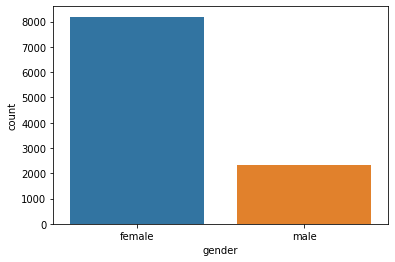

In [266]:
sns.countplot(train['gender'])

More females view then male

In [ ]:
train['startTime'] = pd.to_datetime(train['startTime'])
train['endTime'] = pd.to_datetime(train['endTime'])

In [267]:
train

,session_id,startTime,endTime,ProductList,gender
0,u16159,15/12/14 18:11,15/12/14 18:12,A00002/B00003/C00006/D28435/;A00002/B00003/C00...,female
1,u10253,16/12/14 14:35,16/12/14 14:41,A00001/B00009/C00031/D29404/;A00001/B00009/C00...,male
2,u19037,01/12/14 15:58,01/12/14 15:58,A00002/B00001/C00020/D16944/,female
3,u14556,23/11/14 2:57,23/11/14 3:00,A00002/B00004/C00018/D10284/;A00002/B00004/C00...,female
4,u24295,17/12/14 16:44,17/12/14 16:46,A00001/B00001/C00012/D30805/;A00001/B00001/C00...,male
...,...,...,...,...,...
10495,u15442,18/11/14 7:39,18/11/14 7:42,A00002/B00002/C00007/D06407/;A00002/B00002/C00...,female
10496,u17986,25/11/14 15:16,25/11/14 15:16,A00006/B00030/C00334/D11660/,female
10497,u22508,09/12/14 10:11,09/12/14 10:11,A00002/B00002/C00007/D18028/,female
10498,u17087,22/11/14 11:27,22/11/14 11:27,A00003/B00012/C00131/D09453/;A00003/B00012/C00...,female


We could also see that there is some inconsitency in start and end time

In [268]:
df = train.append(test)

In [269]:
df = df[['session_id','startTime','endTime','ProductList','gender']]

In [270]:
df.head()

,session_id,startTime,endTime,ProductList,gender
0,u16159,15/12/14 18:11,15/12/14 18:12,A00002/B00003/C00006/D28435/;A00002/B00003/C00...,female
1,u10253,16/12/14 14:35,16/12/14 14:41,A00001/B00009/C00031/D29404/;A00001/B00009/C00...,male
2,u19037,01/12/14 15:58,01/12/14 15:58,A00002/B00001/C00020/D16944/,female
3,u14556,23/11/14 2:57,23/11/14 3:00,A00002/B00004/C00018/D10284/;A00002/B00004/C00...,female
4,u24295,17/12/14 16:44,17/12/14 16:46,A00001/B00001/C00012/D30805/;A00001/B00001/C00...,male


In [271]:
df['startTime'] = pd.to_datetime(df['startTime'])
df['endTime'] = pd.to_datetime(df['endTime'])

In [272]:
import numpy as np
from itertools import chain

# return list from series of comma-separated strings
def chainer(s):
    return list(chain.from_iterable(s.str.split(';')))

# calculate lengths of splits
lens = df['ProductList'].str.split(';').map(len)

# create new dataframe, repeating or chaining as appropriate
df1 = pd.DataFrame({'session_id': np.repeat(df['session_id'], lens),
                    'startTime': np.repeat(df['startTime'], lens),
                    'endTime':np.repeat(df['endTime'],lens),
                    'ProductList': chainer(df['ProductList']),
                    'gender':np.repeat(df['gender'],lens)})

print(df1)

     session_id           startTime             endTime  \
0        u16159 2014-12-15 18:11:00 2014-12-15 18:12:00   
0        u16159 2014-12-15 18:11:00 2014-12-15 18:12:00   
0        u16159 2014-12-15 18:11:00 2014-12-15 18:12:00   
0        u16159 2014-12-15 18:11:00 2014-12-15 18:12:00   
1        u10253 2014-12-16 14:35:00 2014-12-16 14:41:00   
...         ...                 ...                 ...   
4497     u13253 2014-11-15 21:38:00 2014-11-15 21:46:00   
4497     u13253 2014-11-15 21:38:00 2014-11-15 21:46:00   
4498     u17094 2014-12-17 08:51:00 2014-12-17 08:51:00   
4499     u24310 2014-12-17 17:25:00 2014-12-17 17:26:00   
4499     u24310 2014-12-17 17:25:00 2014-12-17 17:26:00   

                       ProductList  gender  
0     A00002/B00003/C00006/D28435/  female  
0     A00002/B00003/C00006/D02554/  female  
0     A00002/B00003/C00006/D28436/  female  
0     A00002/B00003/C00006/D28437/  female  
1     A00001/B00009/C00031/D29404/    male  
...                  

In [273]:
df1.head()

,session_id,startTime,endTime,ProductList,gender
0,u16159,2014-12-15 18:11:00,2014-12-15 18:12:00,A00002/B00003/C00006/D28435/,female
0,u16159,2014-12-15 18:11:00,2014-12-15 18:12:00,A00002/B00003/C00006/D02554/,female
0,u16159,2014-12-15 18:11:00,2014-12-15 18:12:00,A00002/B00003/C00006/D28436/,female
0,u16159,2014-12-15 18:11:00,2014-12-15 18:12:00,A00002/B00003/C00006/D28437/,female
1,u10253,2014-12-16 14:35:00,2014-12-16 14:41:00,A00001/B00009/C00031/D29404/,male


In [274]:
df1['TimeTaken'] = abs(df1['endTime'] - df1['startTime']).astype('timedelta64[m]')

In [275]:
df1[['Date','Time']] = df1['startTime'].astype(str).str.split(" ",expand=True) 

In [276]:
df1['Date'] = pd.to_datetime(df1['Date'])

In [277]:
df1['Day'] = df1['Date'].apply(lambda x: x.weekday())

In [278]:
df1.head()

,session_id,startTime,endTime,ProductList,gender,TimeTaken,Date,Time,Day
0,u16159,2014-12-15 18:11:00,2014-12-15 18:12:00,A00002/B00003/C00006/D28435/,female,1.0,2014-12-15,18:11:00,0
0,u16159,2014-12-15 18:11:00,2014-12-15 18:12:00,A00002/B00003/C00006/D02554/,female,1.0,2014-12-15,18:11:00,0
0,u16159,2014-12-15 18:11:00,2014-12-15 18:12:00,A00002/B00003/C00006/D28436/,female,1.0,2014-12-15,18:11:00,0
0,u16159,2014-12-15 18:11:00,2014-12-15 18:12:00,A00002/B00003/C00006/D28437/,female,1.0,2014-12-15,18:11:00,0
1,u10253,2014-12-16 14:35:00,2014-12-16 14:41:00,A00001/B00009/C00031/D29404/,male,6.0,2014-12-16,14:35:00,1


In [279]:
df1['TimeTaken'].max()

486685.0

In [280]:
df1[['Category','SubCategory','SubSubCategory','SubSubSubCategory','Extra']] = df1['ProductList'].str.split("/",expand=True) 

In [281]:
del df1['Extra']
del df1['ProductList']
del df1['Date']
del df1['Time']

In [282]:
len(df1['session_id'].unique())

15000

Changing the orders

In [283]:
df1 = df1[['session_id','TimeTaken','Day','Category','SubCategory','SubSubCategory','SubSubSubCategory','gender']]

In [288]:
df1['TimeTaken'] = df1.TimeTaken.apply(lambda x:int(x))

In [289]:
from sklearn import preprocessing 
columns = ['Category','SubCategory','SubSubCategory','SubSubSubCategory']
label_encoder = preprocessing.LabelEncoder() 
  
for i in columns:
    df1[i]= label_encoder.fit_transform(df1[i]) 
  

In [ ]:
df1['session_id'].describe()

In [290]:
test1 = df1[df1['gender'].isnull() == True]

In [291]:
train1 = df1[df1['gender'].isnull() == False]

In [292]:
train1.head()

,session_id,TimeTaken,Day,Category,SubCategory,SubSubCategory,SubSubSubCategory,gender
0,u16159,1,0,1,2,5,17574,female
0,u16159,1,0,1,2,5,1789,female
0,u16159,1,0,1,2,5,17575,female
0,u16159,1,0,1,2,5,17576,female
1,u10253,6,1,0,8,30,18146,male


In [293]:
test1.head()

,session_id,TimeTaken,Day,Category,SubCategory,SubSubCategory,SubSubSubCategory,gender
0,u12112,0,1,1,2,5,12675,NaN
1,u19725,0,4,1,4,66,1407,NaN
2,u11795,0,6,1,1,3,8129,NaN
3,u22639,3,1,1,2,77,14345,NaN
3,u22639,3,1,1,2,77,14346,NaN


In [294]:
from sklearn import preprocessing 
columns = ['gender']
# label_encoder object knows how to understand word labels. 
label_encoder = preprocessing.LabelEncoder() 
  
for i in columns:
    train1[i]= label_encoder.fit_transform(train1[i]) 
  

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


In [295]:
train1.corr()

,TimeTaken,Day,Category,SubCategory,SubSubCategory,SubSubSubCategory,gender
TimeTaken,1.000000,-0.004406,-0.002682,-0.010162,0.005649,-0.002806,0.022880
Day,-0.004406,1.000000,0.001229,-0.010175,-0.022298,-0.086741,-0.004085
Category,-0.002682,0.001229,1.000000,0.643375,0.426694,0.064299,-0.160770
SubCategory,-0.010162,-0.010175,0.643375,1.000000,0.576950,0.088029,0.131388
SubSubCategory,0.005649,-0.022298,0.426694,0.576950,1.000000,0.129311,0.170450
SubSubSubCategory,-0.002806,-0.086741,0.064299,0.088029,0.129311,1.000000,0.031704
gender,0.022880,-0.004085,-0.160770,0.131388,0.170450,0.031704,1.000000


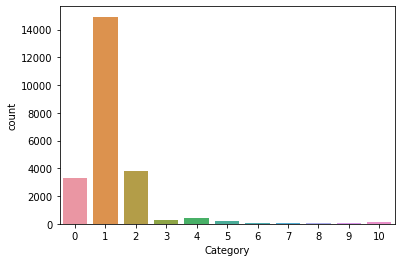

In [296]:
sns.countplot(train1['Category'])

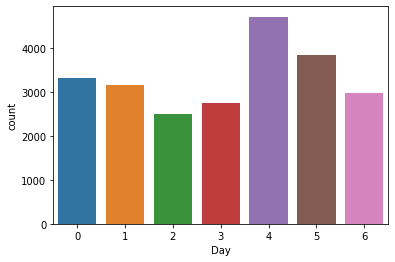

In [297]:
sns.countplot(train1['Day'])

In [298]:
train1.groupby('Day')['gender'].size()

Day
0    3322
1    3150
2    2507
3    2744
4    4708
5    3842
6    2978
Name: gender, dtype: int64

In [299]:
pd.crosstab(train1['Day'],train1['gender'])

gender,0,1
Day,,
0,2569,753
1,2488,662
2,1972,535
3,2268,476
4,3785,923
5,3016,826
6,2312,666


In [300]:
del test1['gender']

In [316]:
def extra_tree(Xtrain,Ytrain,Xtest):
    extra = ExtraTreesClassifier()
    extra.fit(Xtrain, Ytrain) 
    extra_prediction = extra.predict(Xtest)
    return extra_prediction
def Xg_boost(Xtrain,Ytrain,Xtest):
    xg = XGBClassifier(loss='exponential', learning_rate=0.05, n_estimators=1000, subsample=1.0, criterion='friedman_mse', 
                                  min_samples_split=2, 
                                  min_samples_leaf=5, min_weight_fraction_leaf=0.0, max_depth=10, min_impurity_decrease=0.0, 
                                  min_impurity_split=None, 
                                  init=None, random_state=None, max_features=None, verbose=1, max_leaf_nodes=None, warm_start=False, 
                                  presort='deprecated', 
                                  validation_fraction=0.1, n_iter_no_change=None, tol=0.0001)
    xg.fit(Xtrain, Ytrain) 
    xg_prediction = xg.predict(Xtest)
    return xg_prediction
def LGBM(Xtrain,Ytrain,Xtest):
    lgbm = LGBMClassifier(boosting_type='gbdt', num_leaves=40,
                            max_depth=5, learning_rate=0.05, n_estimators=1000, subsample_for_bin=200, objective='binary', 
                            min_split_gain=0.0, min_child_weight=0.001, min_child_samples=10,
                            subsample=1.0, subsample_freq=0, colsample_bytree=1.0, reg_alpha=0.0,
                            reg_lambda=0.0, random_state=None, n_jobs=1, silent=True, importance_type='split')
    #lgbm = LGBMClassifier(n_estimators= 500)
    lgbm.fit(X_train, Y_train)
    lgbm_preds = lgbm.predict(X_test)
    return lgbm_preds

In [304]:
print(train1.columns)
print(test1.columns)

Index(['session_id', 'TimeTaken', 'Day', 'Category', 'SubCategory',
       'SubSubCategory', 'SubSubSubCategory', 'gender'],
      dtype='object')
Index(['session_id', 'TimeTaken', 'Day', 'Category', 'SubCategory',
       'SubSubCategory', 'SubSubSubCategory'],
      dtype='object')


In [305]:
X_train = train1[['TimeTaken','Day','Category', 'SubCategory', 'SubSubCategory','SubSubSubCategory']]
Y_train = train1['gender']
X_test = test1[['TimeTaken','Day', 'Category', 'SubCategory', 'SubSubCategory','SubSubSubCategory']]

In [307]:
X_train.head()
cate_features_index = np.where(X_train.dtypes != float)[0]

In [308]:
xtrain,xtest,ytrain,ytest = train_test_split(X_train,Y_train,train_size=0.99,random_state=1236)

In [309]:
from catboost import Pool, CatBoostClassifier, cv, CatBoostRegressor

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [310]:
model = CatBoostClassifier(iterations=1500, learning_rate=0.001, l2_leaf_reg=3.5, depth=5, 
                           rsm=0.99, loss_function= 'Logloss', eval_metric='AUC',use_best_model=True,random_seed=50)

In [311]:
model.fit(xtrain,ytrain,cat_features=cate_features_index,eval_set=(xtest,ytest))

0:	test: 0.6622878	best: 0.6622878 (0)	total: 46.1ms	remaining: 1m 9s
1:	test: 0.6268310	best: 0.6622878 (0)	total: 77.5ms	remaining: 58.1s
2:	test: 0.6508370	best: 0.6622878 (0)	total: 106ms	remaining: 52.8s
3:	test: 0.6604278	best: 0.6622878 (0)	total: 129ms	remaining: 48.2s
4:	test: 0.6610091	best: 0.6622878 (0)	total: 146ms	remaining: 43.6s
5:	test: 0.6666473	best: 0.6666473 (5)	total: 174ms	remaining: 43.2s
6:	test: 0.6708324	best: 0.6708324 (6)	total: 195ms	remaining: 41.6s
7:	test: 0.6706580	best: 0.6708324 (6)	total: 220ms	remaining: 41.1s
8:	test: 0.6823994	best: 0.6823994 (8)	total: 243ms	remaining: 40.3s
9:	test: 0.6832132	best: 0.6832132 (9)	total: 270ms	remaining: 40.2s
10:	test: 0.6824576	best: 0.6832132 (9)	total: 293ms	remaining: 39.7s
11:	test: 0.6802488	best: 0.6832132 (9)	total: 315ms	remaining: 39.1s
12:	test: 0.6804813	best: 0.6832132 (9)	total: 335ms	remaining: 38.3s
13:	test: 0.6803650	best: 0.6832132 (9)	total: 356ms	remaining: 37.8s
14:	test: 0.6803650	best: 0.

127:	test: 0.7067542	best: 0.7108812 (81)	total: 2.6s	remaining: 27.9s
128:	test: 0.7071030	best: 0.7108812 (81)	total: 2.62s	remaining: 27.9s
129:	test: 0.7072193	best: 0.7108812 (81)	total: 2.64s	remaining: 27.8s
130:	test: 0.7072193	best: 0.7108812 (81)	total: 2.66s	remaining: 27.8s
131:	test: 0.7074518	best: 0.7108812 (81)	total: 2.68s	remaining: 27.8s
132:	test: 0.7075680	best: 0.7108812 (81)	total: 2.7s	remaining: 27.8s
133:	test: 0.7075680	best: 0.7108812 (81)	total: 2.72s	remaining: 27.7s
134:	test: 0.7079168	best: 0.7108812 (81)	total: 2.74s	remaining: 27.7s
135:	test: 0.7080330	best: 0.7108812 (81)	total: 2.75s	remaining: 27.6s
136:	test: 0.7080330	best: 0.7108812 (81)	total: 2.77s	remaining: 27.6s
137:	test: 0.7080330	best: 0.7108812 (81)	total: 2.78s	remaining: 27.5s
138:	test: 0.7080330	best: 0.7108812 (81)	total: 2.8s	remaining: 27.5s
139:	test: 0.7082655	best: 0.7108812 (81)	total: 2.82s	remaining: 27.4s
140:	test: 0.7081493	best: 0.7108812 (81)	total: 2.84s	remaining: 2

248:	test: 0.7303534	best: 0.7311672 (240)	total: 4.92s	remaining: 24.7s
249:	test: 0.7298884	best: 0.7311672 (240)	total: 4.94s	remaining: 24.7s
250:	test: 0.7296559	best: 0.7311672 (240)	total: 4.96s	remaining: 24.7s
251:	test: 0.7303534	best: 0.7311672 (240)	total: 4.98s	remaining: 24.7s
252:	test: 0.7303534	best: 0.7311672 (240)	total: 5s	remaining: 24.6s
253:	test: 0.7305859	best: 0.7311672 (240)	total: 5.02s	remaining: 24.6s
254:	test: 0.7304697	best: 0.7311672 (240)	total: 5.04s	remaining: 24.6s
255:	test: 0.7308184	best: 0.7311672 (240)	total: 5.06s	remaining: 24.6s
256:	test: 0.7304697	best: 0.7311672 (240)	total: 5.08s	remaining: 24.6s
257:	test: 0.7332597	best: 0.7332597 (257)	total: 5.1s	remaining: 24.6s
258:	test: 0.7329110	best: 0.7332597 (257)	total: 5.13s	remaining: 24.6s
259:	test: 0.7326784	best: 0.7332597 (257)	total: 5.14s	remaining: 24.5s
260:	test: 0.7330272	best: 0.7332597 (257)	total: 5.17s	remaining: 24.5s
261:	test: 0.7324459	best: 0.7332597 (257)	total: 5.19s

363:	test: 0.7448849	best: 0.7476750 (338)	total: 7.21s	remaining: 22.5s
364:	test: 0.7447687	best: 0.7476750 (338)	total: 7.24s	remaining: 22.5s
365:	test: 0.7461637	best: 0.7476750 (338)	total: 7.25s	remaining: 22.5s
366:	test: 0.7469774	best: 0.7476750 (338)	total: 7.28s	remaining: 22.5s
367:	test: 0.7468612	best: 0.7476750 (338)	total: 7.29s	remaining: 22.4s
368:	test: 0.7467449	best: 0.7476750 (338)	total: 7.31s	remaining: 22.4s
369:	test: 0.7467449	best: 0.7476750 (338)	total: 7.33s	remaining: 22.4s
370:	test: 0.7461637	best: 0.7476750 (338)	total: 7.35s	remaining: 22.4s
371:	test: 0.7461637	best: 0.7476750 (338)	total: 7.37s	remaining: 22.3s
372:	test: 0.7462799	best: 0.7476750 (338)	total: 7.39s	remaining: 22.3s
373:	test: 0.7462799	best: 0.7476750 (338)	total: 7.41s	remaining: 22.3s
374:	test: 0.7455243	best: 0.7476750 (338)	total: 7.43s	remaining: 22.3s
375:	test: 0.7455243	best: 0.7476750 (338)	total: 7.45s	remaining: 22.3s
376:	test: 0.7455243	best: 0.7476750 (338)	total: 7

477:	test: 0.7513369	best: 0.7513369 (476)	total: 9.59s	remaining: 20.5s
478:	test: 0.7513369	best: 0.7513369 (476)	total: 9.61s	remaining: 20.5s
479:	test: 0.7513369	best: 0.7513369 (476)	total: 9.63s	remaining: 20.5s
480:	test: 0.7513369	best: 0.7513369 (476)	total: 9.65s	remaining: 20.4s
481:	test: 0.7511044	best: 0.7513369 (476)	total: 9.67s	remaining: 20.4s
482:	test: 0.7511044	best: 0.7513369 (476)	total: 9.69s	remaining: 20.4s
483:	test: 0.7507556	best: 0.7513369 (476)	total: 9.71s	remaining: 20.4s
484:	test: 0.7506394	best: 0.7513369 (476)	total: 9.73s	remaining: 20.4s
485:	test: 0.7505231	best: 0.7513369 (476)	total: 9.75s	remaining: 20.3s
486:	test: 0.7508719	best: 0.7513369 (476)	total: 9.77s	remaining: 20.3s
487:	test: 0.7515694	best: 0.7515694 (487)	total: 9.79s	remaining: 20.3s
488:	test: 0.7515694	best: 0.7515694 (487)	total: 9.81s	remaining: 20.3s
489:	test: 0.7513369	best: 0.7515694 (487)	total: 9.83s	remaining: 20.3s
490:	test: 0.7513369	best: 0.7515694 (487)	total: 9

597:	test: 0.7797024	best: 0.7798186 (596)	total: 11.9s	remaining: 18s
598:	test: 0.7792374	best: 0.7798186 (596)	total: 11.9s	remaining: 18s
599:	test: 0.7792374	best: 0.7798186 (596)	total: 12s	remaining: 17.9s
600:	test: 0.7794699	best: 0.7798186 (596)	total: 12s	remaining: 17.9s
601:	test: 0.7800512	best: 0.7800512 (601)	total: 12s	remaining: 17.9s
602:	test: 0.7799349	best: 0.7800512 (601)	total: 12s	remaining: 17.9s
603:	test: 0.7799349	best: 0.7800512 (601)	total: 12s	remaining: 17.9s
604:	test: 0.7802837	best: 0.7802837 (604)	total: 12.1s	remaining: 17.8s
605:	test: 0.7803999	best: 0.7803999 (605)	total: 12.1s	remaining: 17.8s
606:	test: 0.7806324	best: 0.7806324 (606)	total: 12.1s	remaining: 17.8s
607:	test: 0.7806324	best: 0.7806324 (606)	total: 12.1s	remaining: 17.8s
608:	test: 0.7806324	best: 0.7806324 (606)	total: 12.1s	remaining: 17.8s
609:	test: 0.7813299	best: 0.7813299 (609)	total: 12.2s	remaining: 17.7s
610:	test: 0.7813299	best: 0.7813299 (609)	total: 12.2s	remaining

716:	test: 0.7906882	best: 0.7906882 (712)	total: 14.3s	remaining: 15.6s
717:	test: 0.7906882	best: 0.7906882 (712)	total: 14.3s	remaining: 15.6s
718:	test: 0.7906882	best: 0.7906882 (712)	total: 14.3s	remaining: 15.6s
719:	test: 0.7904557	best: 0.7906882 (712)	total: 14.3s	remaining: 15.5s
720:	test: 0.7902232	best: 0.7906882 (712)	total: 14.4s	remaining: 15.5s
721:	test: 0.7902232	best: 0.7906882 (712)	total: 14.4s	remaining: 15.5s
722:	test: 0.7899907	best: 0.7906882 (712)	total: 14.4s	remaining: 15.5s
723:	test: 0.7901070	best: 0.7906882 (712)	total: 14.4s	remaining: 15.5s
724:	test: 0.7899907	best: 0.7906882 (712)	total: 14.4s	remaining: 15.4s
725:	test: 0.7897582	best: 0.7906882 (712)	total: 14.5s	remaining: 15.4s
726:	test: 0.7897582	best: 0.7906882 (712)	total: 14.5s	remaining: 15.4s
727:	test: 0.7897582	best: 0.7906882 (712)	total: 14.5s	remaining: 15.4s
728:	test: 0.7899907	best: 0.7906882 (712)	total: 14.5s	remaining: 15.4s
729:	test: 0.7901070	best: 0.7906882 (712)	total: 1

834:	test: 0.8069635	best: 0.8069635 (834)	total: 16.6s	remaining: 13.2s
835:	test: 0.8070797	best: 0.8070797 (835)	total: 16.6s	remaining: 13.2s
836:	test: 0.8074285	best: 0.8074285 (836)	total: 16.6s	remaining: 13.2s
837:	test: 0.8080098	best: 0.8080098 (837)	total: 16.7s	remaining: 13.2s
838:	test: 0.8082423	best: 0.8082423 (838)	total: 16.7s	remaining: 13.1s
839:	test: 0.8085910	best: 0.8085910 (839)	total: 16.7s	remaining: 13.1s
840:	test: 0.8081260	best: 0.8085910 (839)	total: 16.7s	remaining: 13.1s
841:	test: 0.8080098	best: 0.8085910 (839)	total: 16.7s	remaining: 13.1s
842:	test: 0.8081260	best: 0.8085910 (839)	total: 16.8s	remaining: 13.1s
843:	test: 0.8082423	best: 0.8085910 (839)	total: 16.8s	remaining: 13s
844:	test: 0.8082423	best: 0.8085910 (839)	total: 16.8s	remaining: 13s
845:	test: 0.8081260	best: 0.8085910 (839)	total: 16.8s	remaining: 13s
846:	test: 0.8090560	best: 0.8090560 (846)	total: 16.8s	remaining: 13s
847:	test: 0.8090560	best: 0.8090560 (846)	total: 16.9s	rem

951:	test: 0.8198675	best: 0.8199837 (949)	total: 19.2s	remaining: 11.1s
952:	test: 0.8203325	best: 0.8203325 (952)	total: 19.2s	remaining: 11s
953:	test: 0.8202162	best: 0.8203325 (952)	total: 19.3s	remaining: 11s
954:	test: 0.8201000	best: 0.8203325 (952)	total: 19.3s	remaining: 11s
955:	test: 0.8202162	best: 0.8203325 (952)	total: 19.3s	remaining: 11s
956:	test: 0.8202162	best: 0.8203325 (952)	total: 19.3s	remaining: 11s
957:	test: 0.8202162	best: 0.8203325 (952)	total: 19.3s	remaining: 10.9s
958:	test: 0.8202162	best: 0.8203325 (952)	total: 19.4s	remaining: 10.9s
959:	test: 0.8204487	best: 0.8204487 (959)	total: 19.4s	remaining: 10.9s
960:	test: 0.8204487	best: 0.8204487 (959)	total: 19.4s	remaining: 10.9s
961:	test: 0.8206812	best: 0.8206812 (961)	total: 19.4s	remaining: 10.9s
962:	test: 0.8207975	best: 0.8207975 (962)	total: 19.4s	remaining: 10.8s
963:	test: 0.8207975	best: 0.8207975 (962)	total: 19.5s	remaining: 10.8s
964:	test: 0.8207975	best: 0.8207975 (962)	total: 19.5s	remai

1072:	test: 0.8285864	best: 0.8287026 (1068)	total: 21.7s	remaining: 8.64s
1073:	test: 0.8285864	best: 0.8287026 (1068)	total: 21.7s	remaining: 8.62s
1074:	test: 0.8284701	best: 0.8287026 (1068)	total: 21.8s	remaining: 8.6s
1075:	test: 0.8287026	best: 0.8287026 (1068)	total: 21.8s	remaining: 8.58s
1076:	test: 0.8289351	best: 0.8289351 (1076)	total: 21.8s	remaining: 8.56s
1077:	test: 0.8289351	best: 0.8289351 (1076)	total: 21.8s	remaining: 8.54s
1078:	test: 0.8291676	best: 0.8291676 (1078)	total: 21.8s	remaining: 8.52s
1079:	test: 0.8291676	best: 0.8291676 (1078)	total: 21.9s	remaining: 8.5s
1080:	test: 0.8291676	best: 0.8291676 (1078)	total: 21.9s	remaining: 8.48s
1081:	test: 0.8294001	best: 0.8294001 (1081)	total: 21.9s	remaining: 8.46s
1082:	test: 0.8296326	best: 0.8296326 (1082)	total: 21.9s	remaining: 8.44s
1083:	test: 0.8300977	best: 0.8300977 (1083)	total: 21.9s	remaining: 8.42s
1084:	test: 0.8299814	best: 0.8300977 (1083)	total: 22s	remaining: 8.4s
1085:	test: 0.8298651	best: 0.

1189:	test: 0.8341665	best: 0.8343990 (1187)	total: 24.3s	remaining: 6.32s
1190:	test: 0.8341665	best: 0.8343990 (1187)	total: 24.3s	remaining: 6.3s
1191:	test: 0.8341665	best: 0.8343990 (1187)	total: 24.3s	remaining: 6.28s
1192:	test: 0.8341665	best: 0.8343990 (1187)	total: 24.3s	remaining: 6.26s
1193:	test: 0.8342827	best: 0.8343990 (1187)	total: 24.3s	remaining: 6.24s
1194:	test: 0.8347477	best: 0.8347477 (1194)	total: 24.4s	remaining: 6.22s
1195:	test: 0.8347477	best: 0.8347477 (1194)	total: 24.4s	remaining: 6.2s
1196:	test: 0.8346315	best: 0.8347477 (1194)	total: 24.4s	remaining: 6.18s
1197:	test: 0.8346315	best: 0.8347477 (1194)	total: 24.4s	remaining: 6.16s
1198:	test: 0.8347477	best: 0.8347477 (1194)	total: 24.4s	remaining: 6.14s
1199:	test: 0.8347477	best: 0.8347477 (1194)	total: 24.5s	remaining: 6.12s
1200:	test: 0.8348640	best: 0.8348640 (1200)	total: 24.5s	remaining: 6.1s
1201:	test: 0.8350965	best: 0.8350965 (1201)	total: 24.5s	remaining: 6.08s
1202:	test: 0.8354452	best: 

1305:	test: 0.8392816	best: 0.8392816 (1297)	total: 26.6s	remaining: 3.95s
1306:	test: 0.8392816	best: 0.8392816 (1297)	total: 26.6s	remaining: 3.93s
1307:	test: 0.8393978	best: 0.8393978 (1307)	total: 26.6s	remaining: 3.91s
1308:	test: 0.8393978	best: 0.8393978 (1307)	total: 26.6s	remaining: 3.89s
1309:	test: 0.8393978	best: 0.8393978 (1307)	total: 26.7s	remaining: 3.87s
1310:	test: 0.8393978	best: 0.8393978 (1307)	total: 26.7s	remaining: 3.85s
1311:	test: 0.8393978	best: 0.8393978 (1307)	total: 26.7s	remaining: 3.83s
1312:	test: 0.8397466	best: 0.8397466 (1312)	total: 26.7s	remaining: 3.81s
1313:	test: 0.8398628	best: 0.8398628 (1313)	total: 26.8s	remaining: 3.79s
1314:	test: 0.8403278	best: 0.8403278 (1314)	total: 26.8s	remaining: 3.77s
1315:	test: 0.8404441	best: 0.8404441 (1315)	total: 26.8s	remaining: 3.75s
1316:	test: 0.8405603	best: 0.8405603 (1316)	total: 26.9s	remaining: 3.73s
1317:	test: 0.8406766	best: 0.8406766 (1317)	total: 26.9s	remaining: 3.71s
1318:	test: 0.8406766	bes

1420:	test: 0.8439316	best: 0.8442804 (1417)	total: 28.9s	remaining: 1.61s
1421:	test: 0.8439316	best: 0.8442804 (1417)	total: 28.9s	remaining: 1.59s
1422:	test: 0.8442804	best: 0.8442804 (1417)	total: 29s	remaining: 1.57s
1423:	test: 0.8442804	best: 0.8442804 (1417)	total: 29s	remaining: 1.55s
1424:	test: 0.8442804	best: 0.8442804 (1417)	total: 29s	remaining: 1.53s
1425:	test: 0.8442804	best: 0.8442804 (1417)	total: 29s	remaining: 1.51s
1426:	test: 0.8442804	best: 0.8442804 (1417)	total: 29s	remaining: 1.49s
1427:	test: 0.8445129	best: 0.8445129 (1427)	total: 29.1s	remaining: 1.47s
1428:	test: 0.8445129	best: 0.8445129 (1427)	total: 29.1s	remaining: 1.44s
1429:	test: 0.8445129	best: 0.8445129 (1427)	total: 29.1s	remaining: 1.42s
1430:	test: 0.8445129	best: 0.8445129 (1427)	total: 29.1s	remaining: 1.4s
1431:	test: 0.8445129	best: 0.8445129 (1427)	total: 29.1s	remaining: 1.38s
1432:	test: 0.8447454	best: 0.8447454 (1432)	total: 29.2s	remaining: 1.36s
1433:	test: 0.8449779	best: 0.844977

In [314]:
predss = model.predict(X_test)

In [315]:

test1['gender'] = predss
testn = test1[['session_id','gender']]
print(testn.isna().sum())
test_final = testn.drop_duplicates(subset='session_id', keep='first', inplace=False)
dic = {1:'male',0:'female'}
test_final['gender'] = test_final['gender'].map(dic)
test_final.to_csv('Catboost+day.csv',index = False)

session_id    0
gender        0
dtype: int64


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [317]:
pred_xg = Xg_boost(X_train,Y_train,X_test)
pred_et = extra_tree(X_train,Y_train,X_test)
pred_l = LGBM(X_train,Y_train,X_test)


In [ ]:
# 0 - female, 1 male

In [318]:
test1['gender'] = pred_xg
testn = test1[['session_id','gender']]
print(testn.isna().sum())
test_final = testn.drop_duplicates(subset='session_id', keep='first', inplace=False)
dic = {1:'male',0:'female'}
test_final['gender'] = test_final['gender'].map(dic)
test_final.to_csv('DXG.csv',index = False)

session_id    0
gender        0
dtype: int64


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [319]:
test1['gender'] = pred_et
testn = test1[['session_id','gender']]
print(testn.isna().sum())
test_final = testn.drop_duplicates(subset='session_id', keep='first', inplace=False)
dic = {1:'male',0:'female'}
test_final['gender'] = test_final['gender'].map(dic)
test_final.to_csv('DETC.csv',index = False)

session_id    0
gender        0
dtype: int64


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [320]:

test1['gender'] = pred_l
testn = test1[['session_id','gender']]
print(testn.isna().sum())
test_final = testn.drop_duplicates(subset='session_id', keep='first', inplace=False)
dic = {1:'male',0:'female'}
test_final['gender'] = test_final['gender'].map(dic)
test_final.to_csv('DLGBM.csv',index = False)


session_id    0
gender        0
dtype: int64


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [321]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(random_state=0).fit(X_train, Y_train)
ans = clf.predict(X_test)


/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [323]:
print(len(pred_l))
test1['gender'] = ans
testn = test1[['session_id','gender']]
print(testn.isna().sum())
test_final = testn.drop_duplicates(subset='session_id', keep='first', inplace=False)
dic = {1:'male',0:'female'}
test_final['gender'] = test_final['gender'].map(dic)
test_final.to_csv('DLR.csv',index = False)

10204
session_id    0
gender        0
dtype: int64


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


In [324]:
from sklearn.ensemble import AdaBoostClassifier
ada = AdaBoostClassifier(n_estimators=100).fit(X_train, Y_train)
prediction_of_ada = ada.predict(X_test)

In [325]:
from sklearn.ensemble import GradientBoostingClassifier
gbc = GradientBoostingClassifier(loss='exponential', learning_rate=0.1, n_estimators=100, subsample=1.0, criterion='friedman_mse', 
                                  min_samples_split=2, 
                                  min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_depth=10, min_impurity_decrease=0.0, 
                                  min_impurity_split=None, 
                                  init=None, random_state=None, max_features=None, verbose=0, max_leaf_nodes=None, warm_start=False, 
                                  presort='deprecated', 
                                  validation_fraction=0.1, n_iter_no_change=None, tol=0.0001).fit(X_train, Y_train)
prediction_of_gbc = gbc.predict(X_test)

In [326]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=10).fit(X_train, Y_train)
prediction_of_rf = rf.predict(X_test)

In [327]:

test1['gender'] = prediction_of_ada
testn = test1[['session_id','gender']]
print(testn.isna().sum())
test_final = testn.drop_duplicates(subset='session_id', keep='first', inplace=False)
dic = {1:'male',0:'female'}
test_final['gender'] = test_final['gender'].map(dic)
test_final.to_csv('DADA.csv',index = False)

session_id    0
gender        0
dtype: int64


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [328]:

test1['gender'] = prediction_of_gbc
testn = test1[['session_id','gender']]
print(testn.isna().sum())
test_final = testn.drop_duplicates(subset='session_id', keep='first', inplace=False)
dic = {1:'male',0:'female'}
test_final['gender'] = test_final['gender'].map(dic)
test_final.to_csv('Dgbc.csv',index = False)

session_id    0
gender        0
dtype: int64


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [329]:

test1['gender'] = prediction_of_rf
testn = test1[['session_id','gender']]
print(testn.isna().sum())
test_final = testn.drop_duplicates(subset='session_id', keep='first', inplace=False)
dic = {1:'male',0:'female'}
test_final['gender'] = test_final['gender'].map(dic)
test_final.to_csv('DRF.csv',index = False)

session_id    0
gender        0
dtype: int64


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [330]:
from sklearn.neighbors import KNeighborsClassifier
neigh = KNeighborsClassifier(n_neighbors=3)
neigh.fit(X_train,Y_train)

# Predicted class
nri = neigh.predict(X_test)


In [331]:

test1['gender'] = nri
testn = test1[['session_id','gender']]
print(testn.isna().sum())
test_final = testn.drop_duplicates(subset='session_id', keep='first', inplace=False)
dic = {1:'male',0:'female'}
test_final['gender'] = test_final['gender'].map(dic)
test_final.to_csv('Dknn.csv',index = False)

session_id    0
gender        0
dtype: int64


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [332]:
from sklearn.calibration import CalibratedClassifierCV

In [333]:
model = XGBClassifier()
metLearn=CalibratedClassifierCV(model, method='isotonic', cv=2)
metLearn.fit(X_train, Y_train)
testPredictions = metLearn.predict(X_test)

In [ ]:
def submissions(predictions_by_model,string):
    test1['gender'] = predictions_by_model
    testn = test1[['session_id','gender']]
    print(testn.isna().sum())
    test_final = testn.drop_duplicates(subset='session_id', keep='first', inplace=False)
    dic = {1:'male',0:'female'}
    test_final['gender'] = test_final['gender'].map(dic)
    test_final.to_csv(string.csv,index = False)


In [334]:
test1['gender'] = testPredictions
testn = test1[['session_id','gender']]
print(testn.isna().sum())
test_final = testn.drop_duplicates(subset='session_id', keep='first', inplace=False)
dic = {1:'male',0:'female'}
test_final['gender'] = test_final['gender'].map(dic)
test_final.to_csv('DCCV.csv',index = False)

session_id    0
gender        0
dtype: int64


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [335]:
import pandas as pd
from sklearn.metrics import roc_auc_score
import lightgbm as lgb
import matplotlib.pyplot as plt

# sklearn tools for model training and assesment
from sklearn.model_selection import train_test_split
from sklearn.model_selection import PredefinedSplit
from sklearn.model_selection import GridSearchCV, ParameterGrid
from sklearn.metrics import (roc_curve, auc, accuracy_score)

# specify your configurations as a dict
params = {
    'task': 'train',
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'metric': {'binary_logloss', 'auc'},
    'metric_freq': 1,
    'is_training_metric': True,
    'max_bin': 255,
    'learning_rate': 0.1,
    'num_leaves': 63,
    'tree_learner': 'serial',
    'feature_fraction': 0.8,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'min_data_in_leaf': 50,
    'min_sum_hessian_in_leaf': 5,
    'is_enable_sparse': True,
    'use_two_round_loading': False,
    'is_save_binary_file': False,
    'output_model': 'LightGBM_model.txt',
    'num_machines': 1,
    'local_listen_port': 12400,
    'machine_list_file': 'mlist.txt',
    'verbose': 0,
    'subsample_for_bin': 200000,
    'min_child_samples': 20,
    'min_child_weight': 0.001,
    'min_split_gain': 0.0,
    'colsample_bytree': 1.0,
    'reg_alpha': 0.0,
    'reg_lambda': 0.0
}


lgb_train = lgb.Dataset(X_train, Y_train)

 

In [336]:
lgb_train

In [337]:
lgb_eval = lgb.Dataset(X_test)

In [338]:
# train
gbm = lgb.train(params,
                lgb_train,
                valid_sets=lgb_eval)

[1]	valid_0's auc: 1	valid_0's binary_logloss: 0.235992
[2]	valid_0's auc: 1	valid_0's binary_logloss: 0.238879
[3]	valid_0's auc: 1	valid_0's binary_logloss: 0.241681
[4]	valid_0's auc: 1	valid_0's binary_logloss: 0.245485
[5]	valid_0's auc: 1	valid_0's binary_logloss: 0.249652
[6]	valid_0's auc: 1	valid_0's binary_logloss: 0.253628
[7]	valid_0's auc: 1	valid_0's binary_logloss: 0.258339
[8]	valid_0's auc: 1	valid_0's binary_logloss: 0.263113
[9]	valid_0's auc: 1	valid_0's binary_logloss: 0.267837
[10]	valid_0's auc: 1	valid_0's binary_logloss: 0.272565
[11]	valid_0's auc: 1	valid_0's binary_logloss: 0.277579
[12]	valid_0's auc: 1	valid_0's binary_logloss: 0.282661
[13]	valid_0's auc: 1	valid_0's binary_logloss: 0.287576
[14]	valid_0's auc: 1	valid_0's binary_logloss: 0.2925
[15]	valid_0's auc: 1	valid_0's binary_logloss: 0.296731
[16]	valid_0's auc: 1	valid_0's binary_logloss: 0.301563
[17]	valid_0's auc: 1	valid_0's binary_logloss: 0.305921
[18]	valid_0's auc: 1	valid_0's binary_log

In [340]:



gridParams = {
    'learning_rate': [ 0.1],
    'num_leaves': [63],
    'boosting_type' : ['gbdt'],
    'objective' : ['binary']
}

mdl = lgb.LGBMClassifier(
    task = params['task'],
    metric = params['metric'],
    metric_freq = params['metric_freq'],
    is_training_metric = params['is_training_metric'],
    max_bin = params['max_bin'],
    tree_learner = params['tree_learner'],
    feature_fraction = params['feature_fraction'],
    bagging_fraction = params['bagging_fraction'],
    bagging_freq = params['bagging_freq'],
    min_data_in_leaf = params['min_data_in_leaf'],
    min_sum_hessian_in_leaf = params['min_sum_hessian_in_leaf'],
    is_enable_sparse = params['is_enable_sparse'],
    use_two_round_loading = params['use_two_round_loading'],
    is_save_binary_file = params['is_save_binary_file'],
    n_jobs = -1
)

scoring = {'AUC': 'roc_auc'}

# Create the grid
#grid = GridSearchCV(mdl, gridParams, verbose=2, cv=5, scoring=scoring, n_jobs=-1, refit='AUC')
# Run the grid


#print('Best parameters found by grid search are:', grid.best_params_)
#print('Best score found by grid search is:', grid.best_score_)


In [342]:
yes = gbm.predict(X_test)

In [344]:
yess =[]
for i in yes:
    if i>=0.5:
        yess.append(1)
    else:
        yess.append(0)

In [345]:
test1['gender'] = yess
testn = test1[['session_id','gender']]
print(testn.isna().sum())
test_final = testn.drop_duplicates(subset='session_id', keep='first', inplace=False)
dic = {1:'male',0:'female'}
test_final['gender'] = test_final['gender'].map(dic)
test_final.to_csv('DDCCV.csv',index = False)

session_id    0
gender        0
dtype: int64


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
